In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from botorch.utils.sampling import draw_sobol_samples 
import numpy as np 
import json

import sys
sys.path.append('..')
import sample_utilities.samples as samples
import uuid

import scipy
from scipy.stats.qmc import Sobol
from scipy.stats import qmc

import pandas as pd
import seaborn as sns

## Load bounds

In [3]:
target_volume = 10000

In [4]:
with open('Mesoporous_constants_APS_batch.json', 'r') as f:
    constants = json.load(f)


ctab_lower_vf = constants['ctab']['minimum_mass']/constants['ctab']['stock_concentration_mg_uL']/target_volume  
f127_lower_vf = constants['f127']['minimum_mass']/constants['f127']['stock_concentration_mg_uL']/target_volume

ctab_upper_vf = constants['ctab']['maximum_mass']/constants['ctab']['stock_concentration_mg_uL']/target_volume
f127_upper_vf = constants['f127']['maximum_mass']/constants['f127']['stock_concentration_mg_uL']/target_volume

lower_bounds = [constants['TEOS']['minimum_volume_fraction'],
                constants['ammonia']['minimum_volume_fraction'],
                constants['ethanol']['minimum_volume_fraction'],
                constants['ctab']['minimum_mass'],
                constants['f127']['minimum_mass']]

upper_bounds = [constants['TEOS']['maximum_volume_fraction'],
                constants['ammonia']['maximum_volume_fraction'],
                constants['ethanol']['maximum_volume_fraction'],
                constants['ctab']['maximum_mass'],
                constants['f127']['maximum_mass']]

In [5]:
ctab_upper_vf

0.6666666666666667

In [6]:
n_samples = 80

In [7]:
def constrained_sobol_sampling_rejection(n: int, num_samples: int, m_samples = 8, seed: int = None):
    """
    Generates Sobol samples in n dimensions satisfying:
    a) Sum of all components = 1.0
    b) Last component (nth dim) is in [0.4, 1.0]

    Uses rejection sampling: Generates a large pool and filters valid samples.

    Args:
        n (int): Number of dimensions.
        num_samples (int): Number of valid samples to return.
        pool_size (int): Number of initial samples to generate before filtering.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        torch.Tensor: (num_samples, n) tensor of valid samples.
    """
    if seed is not None:
        torch.manual_seed(seed)

    valid_samples = []
    
    while len(valid_samples) < num_samples:
        print('Number valid samples: ', len(valid_samples))
        # Generate Sobol samples in [0,1]^n
        #sobol_samples = draw_sobol_samples(bounds=torch.tensor([[0.0] * n, [1.0] * n]), n=pool_size, q=1).squeeze(1)
        sampler = Sobol(d=n, seed = seed)
        sampled_points = sampler.random_base2(m_samples)
    
        sampled_volume_fractions = qmc.scale(sampled_points, lower_bounds, upper_bounds)


        for i in range(len(sampled_volume_fractions)):
            teos_vol_frac = sampled_volume_fractions[i, 0]
            ammonia_vol_frac = sampled_volume_fractions[i, 1]
            ethanol_vol_frac = sampled_volume_fractions[i, 2]
            # convert surfactant mass to volumes
            ctab_mass = sampled_volume_fractions[i, 3]
            f127_mass = sampled_volume_fractions[i, 4]
    
            ctab_vol_frac = ctab_mass/constants['ctab']['stock_concentration_mg_uL']/target_volume
            f127_vol_frac = f127_mass/constants['f127']['stock_concentration_mg_uL']/target_volume
    
            water_from_surfactant_vf = ctab_vol_frac+f127_vol_frac
    
            
    
            water_min_vf = constants['water']['minimum_volume_fraction']
    
            # water that needs to be delivered to meet minimum volume fraction
            water_min_vf_delivered = max(water_min_vf-water_from_surfactant_vf, 0)
    
            max_other_components = 1 - water_min_vf_delivered

            print(max_other_components)
    
    
            sum_nonwater_additions = teos_vol_frac + ammonia_vol_frac + ethanol_vol_frac + ctab_vol_frac + f127_vol_frac
            sum_water_free_additions = teos_vol_frac + ammonia_vol_frac + ethanol_vol_frac
            if sum_nonwater_additions < max_other_components:

                water_vol_frac = 1 - sum_water_free_additions
                sample = [teos_vol_frac, ammonia_vol_frac, ethanol_vol_frac, ctab_mass, f127_mass, water_vol_frac]
                
                print('found valid sample: ', sample)
                valid_samples.append(sample)

    return valid_samples[0:num_samples]


In [8]:
baseline_samples = constrained_sobol_sampling_rejection(5, n_samples, m_samples= 7)

Number valid samples:  0
1
1
0.9032581993068258
found valid sample:  [np.float64(0.029078077091369777), np.float64(0.07154942587018014), np.float64(0.2638955280184746), np.float64(26.37287873774767), np.float64(13.719503860920668), np.float64(0.6354769690199755)]
1
1
0.8913742101440827
found valid sample:  [np.float64(0.025944420353509485), np.float64(0.02172024208121002), np.float64(0.20337791144847872), np.float64(16.721469024196267), np.float64(39.94887499138713), np.float64(0.7489574261168017)]
1
found valid sample:  [np.float64(0.03100141024403274), np.float64(0.05281122215092183), np.float64(0.3090571448206902), np.float64(55.51016453653574), np.float64(108.00499990582466), np.float64(0.6071302227843552)]
1
1
found valid sample:  [np.float64(0.020016696523409334), np.float64(0.07923576537519693), np.float64(0.31535196695476775), np.float64(13.229657765477896), np.float64(124.37266381457448), np.float64(0.585395571146626)]
1
1
1
found valid sample:  [np.float64(0.01011105818720534

In [9]:
teos_vf = []
ammonia_vf = []
ethanol_vf = []
ctab_vf = []
f127_vf = []
water_vf = []

for sample in baseline_samples:
    sample_sum = 0
    teos_vf.append(sample[0])
    ammonia_vf.append(sample[1])
    ethanol_vf.append(sample[2])
    ctab_vf.append(sample[3])
    f127_vf.append(sample[4])
    water_vf.append(sample[5])
    for entry in sample:
        sample_sum += entry
    print('Sample sum: ', sample_sum)


Sample sum:  41.09238259866834
Sample sum:  57.670344015583396
Sample sum:  164.5151644423604
Sample sum:  138.60232158005238
Sample sum:  89.15601534210145
Sample sum:  141.99991479888558
Sample sum:  108.61930172331631
Sample sum:  54.684702310711145
Sample sum:  93.83163785003126
Sample sum:  253.57910090498626
Sample sum:  156.20708940923214
Sample sum:  141.13381344266233
Sample sum:  185.99425573274493
Sample sum:  148.68235477618873
Sample sum:  178.67361588776112
Sample sum:  219.26468584127724
Sample sum:  181.72523979470134
Sample sum:  119.81198939867319
Sample sum:  62.07216291129589
Sample sum:  108.22398046404123
Sample sum:  117.6433014255017
Sample sum:  172.6644853912294
Sample sum:  81.00421927310526
Sample sum:  91.86435158737004
Sample sum:  156.1967135630548
Sample sum:  49.6995542794466
Sample sum:  78.09693458862603
Sample sum:  73.49564573168756
Sample sum:  268.59002218954265
Sample sum:  131.305133825168
Sample sum:  206.3045929968357
Sample sum:  100.27156039

In [10]:
len(baseline_samples)

80

In [11]:
raw_vfs = pd.DataFrame({'teos_vf':teos_vf, 'ammonia_vf':ammonia_vf, 'ethanol_vf':ethanol_vf, 'ctab_vf':ctab_vf, 'f127_vf':f127_vf, 'water_vf':water_vf})

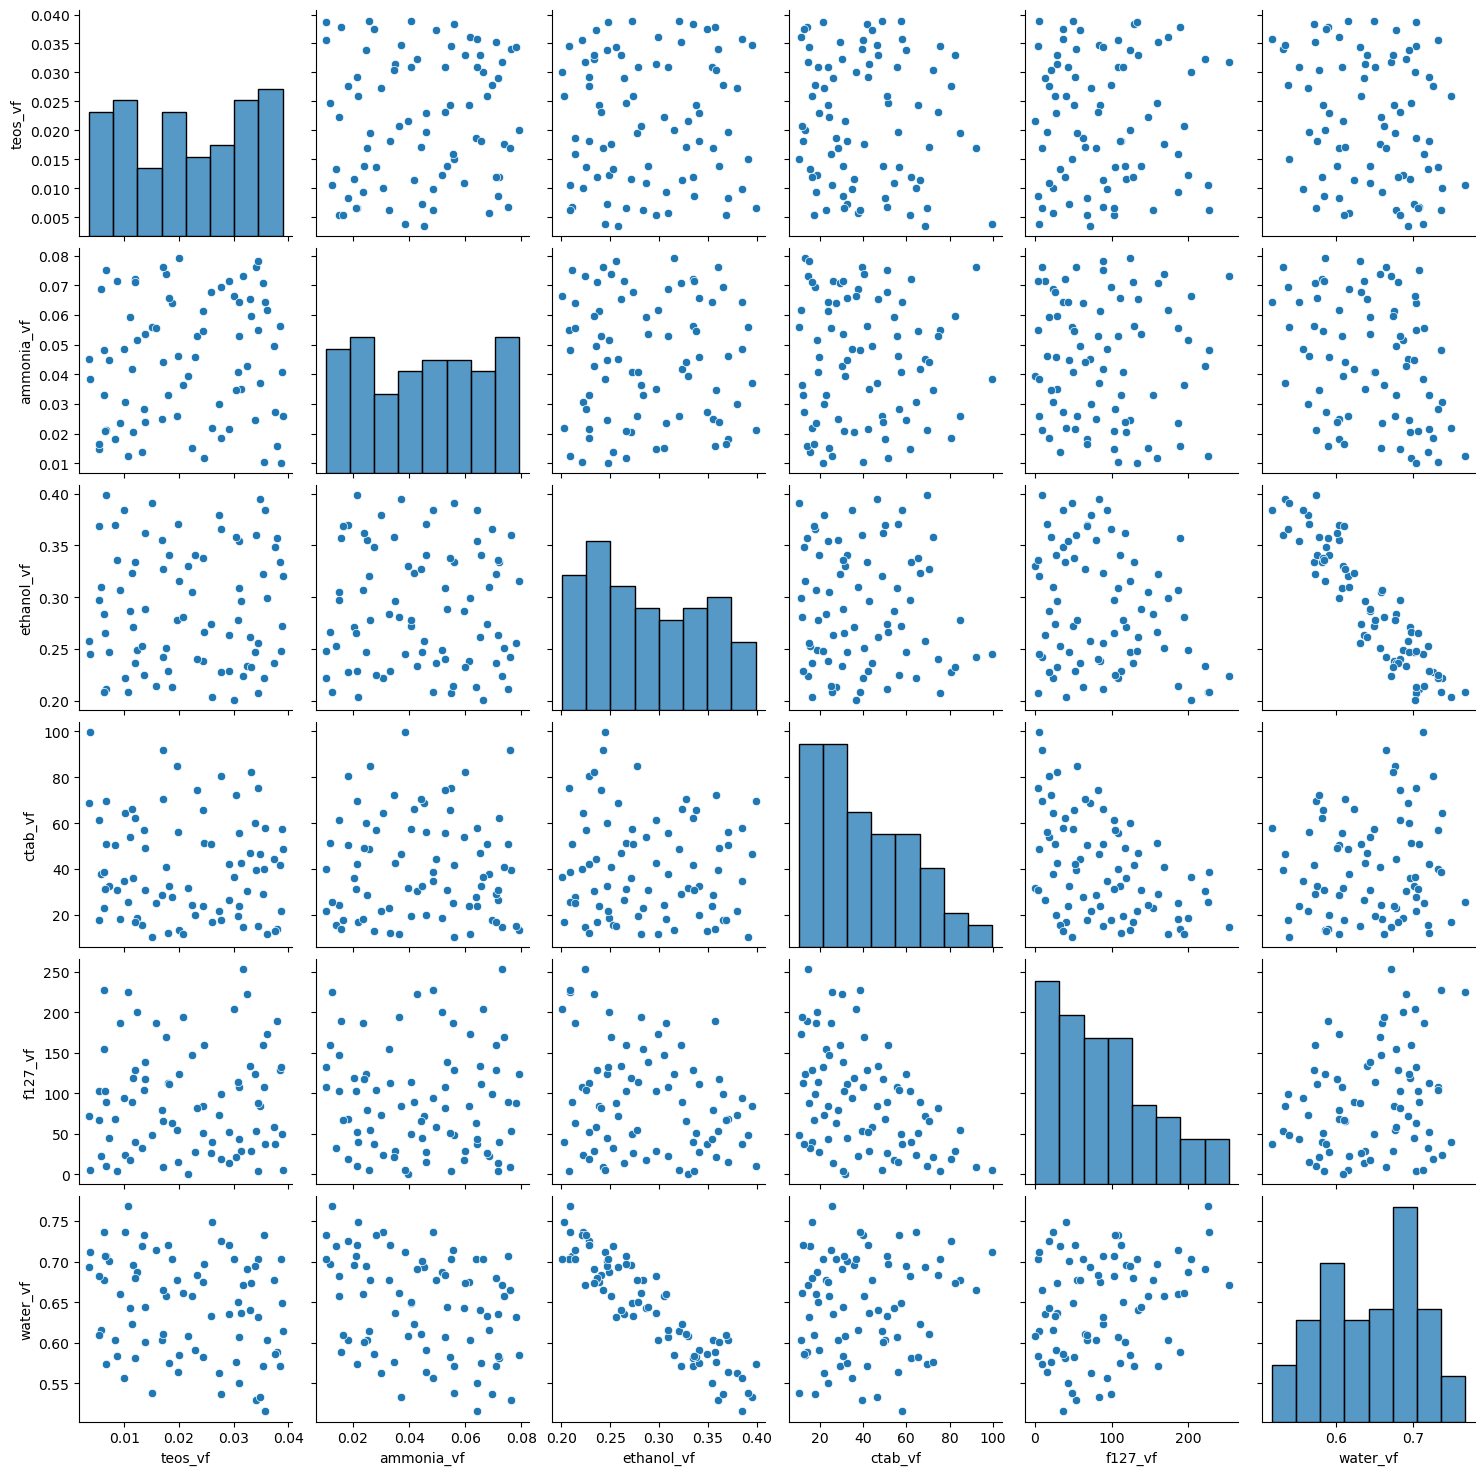

In [12]:
sns.pairplot(raw_vfs)

In [13]:
uuid_vals = [uuid.uuid4() for val in baseline_samples]
teos_volume = [target_volume*entry[0] for entry in baseline_samples]

In [14]:
samples_gen = []
for i in range(len(baseline_samples)):
    row = baseline_samples[i]
    sample = samples.MesoporousSample(target_volume=target_volume, reactant_fp='Mesoporous_constants_APS.json', teos_vol_frac=row[0], ammonia_vol_frac=row[1], ethanol_vol_frac=row[2], ctab_mass=row[3], f127_mass=row[4], water_vol_frac=row[5])
    sample.calculate_reactant_volumes()
    #sample.calculate_silica_mass_concentration()
    #sample.calculate_silica_mass_fraction()
    #sample.calculate_dilution_volumefraction(target_dilution)
    samples_gen.append(sample)
    print('final etoh vol: ', sample.ethanol_volume)

TEOS ETOH:  537.9444261903409
Solvent etoh total:  537.9444261903409
final etoh vol:  2101.010853994405
TEOS ETOH:  479.9717765399255
Solvent etoh total:  479.9717765399255
final etoh vol:  1553.8073379448617
TEOS ETOH:  573.5260895146057
Solvent etoh total:  573.5260895146057
final etoh vol:  2517.0453586922963
TEOS ETOH:  370.3088856830727
Solvent etoh total:  370.3088856830727
final etoh vol:  2783.2107838646048
TEOS ETOH:  187.05457646329887
Solvent etoh total:  187.05457646329887
final etoh vol:  2034.733824320836
TEOS ETOH:  65.58151814294979
Solvent etoh total:  65.58151814294979
final etoh vol:  2512.302360579837
TEOS ETOH:  312.2950597759336
Solvent etoh total:  312.2950597759336
final etoh vol:  3236.4452023897325
TEOS ETOH:  720.1819561845624
Solvent etoh total:  720.1819561845624
final etoh vol:  2482.4676706963223
TEOS ETOH:  630.3921458174009
Solvent etoh total:  630.3921458174009
final etoh vol:  2966.653145397781
TEOS ETOH:  599.2318406009581
Solvent etoh total:  599.23

In [15]:
sample.water_volume

np.float64(677.8486386997001)

In [16]:
uuid_vals = []
teos_volumes = []
ammonia_volumes = []
ethanol_volumes = []
water_volumes = []
ctab_volumes = []
f127_volumes = []
sample_names = []

for i, sample in enumerate(samples_gen):
    sample_names.append(f'SobolBatch_{i+1}')
    uuid_vals.append(uuid.uuid4())
    teos_volumes.append(sample.teos_volume)
    ammonia_volumes.append(sample.ammonia_volume)
    ethanol_volumes.append(sample.ethanol_volume)
    water_volumes.append(sample.water_volume)
    ctab_volumes.append(sample.ctab_volume)
    f127_volumes.append(sample.f127_volume)\

    total_volume = sample.teos_volume+sample.ammonia_volume + sample.water_volume + sample.ethanol_volume + sample.ctab_volume + sample.f127_volume
    print(f'Total volume sample SobolBaseline_{i+1}: {total_volume}')



Total volume sample SobolBaseline_1: 10000.0
Total volume sample SobolBaseline_2: 9999.999999999998
Total volume sample SobolBaseline_3: 10000.0
Total volume sample SobolBaseline_4: 10000.0
Total volume sample SobolBaseline_5: 10000.0
Total volume sample SobolBaseline_6: 10000.0
Total volume sample SobolBaseline_7: 9999.999999999998
Total volume sample SobolBaseline_8: 10000.0
Total volume sample SobolBaseline_9: 10000.0
Total volume sample SobolBaseline_10: 10000.0
Total volume sample SobolBaseline_11: 10000.0
Total volume sample SobolBaseline_12: 10000.0
Total volume sample SobolBaseline_13: 10000.0
Total volume sample SobolBaseline_14: 10000.0
Total volume sample SobolBaseline_15: 10000.0
Total volume sample SobolBaseline_16: 10000.0
Total volume sample SobolBaseline_17: 10000.0
Total volume sample SobolBaseline_18: 10000.0
Total volume sample SobolBaseline_19: 10000.0
Total volume sample SobolBaseline_20: 10000.0
Total volume sample SobolBaseline_21: 10000.0
Total volume sample Sob

In [17]:
sample_table = pd.DataFrame({'sample_name':sample_names,
                             'uuid':uuid_vals,
                             'teos_volume':teos_volumes,
                             'ammonia_volume':ammonia_volumes,
                             'water_volume':water_volumes,
                             'ethanol_volume':ethanol_volumes,
                             'ctab_volume':ctab_volumes,
                             'F127_volume':f127_volumes
                            })

In [18]:
sample_table

,sample_name,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,ctab_volume,F127_volume
0,SobolBatch_1,83caa81b-c9ac-4b2f-b7b6-97a05c42f277,828.725197,715.494259,4322.187697,2101.010854,1758.191916,274.390077
1,SobolBatch_2,285271f3-055d-4edd-9cdd-3322ed1140ed,739.415980,217.202421,5575.832160,1553.807338,1114.764602,798.977500
2,SobolBatch_3,8f86f557-5b97-4a80-b8da-55a55056d4b5,883.540192,528.112222,210.524594,2517.045359,3700.677636,2160.099998
3,SobolBatch_4,0491adba-e277-4475-aee0-af111005fd40,570.475851,792.357654,2484.525251,2783.210784,881.977184,2487.453276
4,SobolBatch_5,586e06c8-0f02-43a3-9f2f-81e46d43ef64,288.165158,306.373455,2593.689300,2034.733824,4305.597079,471.441183
...,...,...,...,...,...,...,...,...
75,SobolBatch_76,4de2e734-e313-400b-b4e5-2817f8478e1c,178.102264,483.436935,247.239871,1971.350346,2567.553040,4552.317543
76,SobolBatch_77,db17e40c-71da-4e97-8660-7918dee0e954,154.427788,165.795203,3574.276972,3582.069010,1169.978902,1353.452124
77,SobolBatch_78,f0cd21ec-eaad-4b54-aeae-d5a3bf6f5c0b,388.439717,282.341696,1445.897968,2000.454765,3792.703204,2090.162650
78,SobolBatch_79,50909d33-3594-4edc-b54e-5c1dcdde3094,245.405401,715.307893,3713.554608,3199.979417,2047.251681,78.500999


In [19]:
## Insert controls
def insert_row(df, new_row, index):
    """
    Inserts a new row into a DataFrame at a specific index.

    Parameters:
    df (pd.DataFrame): The original DataFrame.
    new_row (dict): The row to insert, as a dictionary.
    index (int): The position to insert the new row.

    Returns:
    pd.DataFrame: A new DataFrame with the inserted row.
    """
    df1 = df.iloc[:index]  # Rows before insertion
    df2 = pd.DataFrame([new_row])  # New row as DataFrame
    df3 = df.iloc[index:]  # Rows after insertion

    return pd.concat([df1, df2, df3]).reset_index(drop=True)

In [20]:
n_controls = 6

control_teos_vol = 495.350825
control_ammonia_vol = 482.903414
control_water_vol = 2348.633956
control_ethanol_vol = 2721.331679
control_ctab_vol = 1907.18017
control_f127_vol = 2044.599948

controls = []
for i in range(n_controls):
    controls.append({'sample_name':f'SobolBatch_control_{i+1}', 'uuid':uuid.uuid4(), 'teos_volume':control_teos_vol, 'ammonia_volume':control_ammonia_vol, 'water_volume':control_water_vol, 'ethanol_volume':control_ethanol_vol, 'ctab_volume':control_ctab_vol, 'F127_volume':control_f127_vol})

control_inds = [0, 1, 2, 28, 52, 76]

for i, control in enumerate(controls):
    sample_table = insert_row(sample_table, control, control_inds[i])


In [21]:
controls

[{'sample_name': 'SobolBatch_control_1',
  'uuid': UUID('5dfdbe5e-3f38-44de-b9db-65c72c27f02e'),
  'teos_volume': 495.350825,
  'ammonia_volume': 482.903414,
  'water_volume': 2348.633956,
  'ethanol_volume': 2721.331679,
  'ctab_volume': 1907.18017,
  'F127_volume': 2044.599948},
 {'sample_name': 'SobolBatch_control_2',
  'uuid': UUID('93780a39-35f5-4c85-963b-2fde66396c78'),
  'teos_volume': 495.350825,
  'ammonia_volume': 482.903414,
  'water_volume': 2348.633956,
  'ethanol_volume': 2721.331679,
  'ctab_volume': 1907.18017,
  'F127_volume': 2044.599948},
 {'sample_name': 'SobolBatch_control_3',
  'uuid': UUID('00afc63f-86d3-41a0-9f37-8d56c6d1abfd'),
  'teos_volume': 495.350825,
  'ammonia_volume': 482.903414,
  'water_volume': 2348.633956,
  'ethanol_volume': 2721.331679,
  'ctab_volume': 1907.18017,
  'F127_volume': 2044.599948},
 {'sample_name': 'SobolBatch_control_4',
  'uuid': UUID('700aac34-3c22-475d-a2cc-8a678987fb32'),
  'teos_volume': 495.350825,
  'ammonia_volume': 482.9034

In [22]:
sample_table

,sample_name,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,ctab_volume,F127_volume
0,SobolBatch_control_1,5dfdbe5e-3f38-44de-b9db-65c72c27f02e,495.350825,482.903414,2348.633956,2721.331679,1907.180170,2044.599948
1,SobolBatch_control_2,93780a39-35f5-4c85-963b-2fde66396c78,495.350825,482.903414,2348.633956,2721.331679,1907.180170,2044.599948
2,SobolBatch_control_3,00afc63f-86d3-41a0-9f37-8d56c6d1abfd,495.350825,482.903414,2348.633956,2721.331679,1907.180170,2044.599948
3,SobolBatch_1,83caa81b-c9ac-4b2f-b7b6-97a05c42f277,828.725197,715.494259,4322.187697,2101.010854,1758.191916,274.390077
4,SobolBatch_2,285271f3-055d-4edd-9cdd-3322ed1140ed,739.415980,217.202421,5575.832160,1553.807338,1114.764602,798.977500
...,...,...,...,...,...,...,...,...
81,SobolBatch_76,4de2e734-e313-400b-b4e5-2817f8478e1c,178.102264,483.436935,247.239871,1971.350346,2567.553040,4552.317543
82,SobolBatch_77,db17e40c-71da-4e97-8660-7918dee0e954,154.427788,165.795203,3574.276972,3582.069010,1169.978902,1353.452124
83,SobolBatch_78,f0cd21ec-eaad-4b54-aeae-d5a3bf6f5c0b,388.439717,282.341696,1445.897968,2000.454765,3792.703204,2090.162650
84,SobolBatch_79,50909d33-3594-4edc-b54e-5c1dcdde3094,245.405401,715.307893,3713.554608,3199.979417,2047.251681,78.500999


In [23]:
vial_volume = 17000
cols = ['teos_volume', 'ammonia_volume', 'ethanol_volume', 'water_volume', 'ctab_volume', 'F127_volume']
for col in cols:
    total_volume = sample_table[col].sum()
    print(f'Total volume {col} required: {total_volume/1000}')
    n_vials = total_volume/vial_volume
    print(f'Volume for {col}: {total_volume}, vials required: {n_vials}')

Total volume teos_volume required: 52.355503337603224
Volume for teos_volume: 52355.50333760322, vials required: 3.0797354904472485
Total volume ammonia_volume required: 38.577745998543804
Volume for ammonia_volume: 38577.7459985438, vials required: 2.26927917638493
Total volume ethanol_volume required: 215.47810409121396
Volume for ethanol_volume: 215478.10409121396, vials required: 12.675182593600821
Total volume water_volume required: 168.94252838570094
Volume for water_volume: 168942.52838570095, vials required: 9.937795787394174
Total volume ctab_volume required: 228.57064043910046
Volume for ctab_volume: 228570.64043910045, vials required: 13.44533179053532
Total volume F127_volume required: 156.0754776998376
Volume for F127_volume: 156075.4776998376, vials required: 9.180910452931624


In [127]:
sample_table.to_csv('Mesoporous_SobolBaseline_APS_BatchMode_3_29_25.csv')